# Time Serices Model for Energy Consumption.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from prophet.plot import plot, plot_components
from prophet.diagnostics import cross_validation, performance_metrics
from scipy import stats


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
# Function to convet the dates into date time format.
def time_conversion(data):
    # Time conversion.
    data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

    return data

In [3]:
# Function to generate boxplots.
def box_plot(data, name):
    # Create the boxplot
    plt.boxplot(data['kWh'])

    # Add title and labels
    plt.title(name)
    plt.ylabel('Value')

    # Display the plot
    plt.show()

In [4]:
# Function to remove outliers.
def remove_outliers(data):
        # Define the the first quartile.
        q1 = data['kWh'].quantile(0.25)
        # Define the 3rd quartile. 
        q3 = data['kWh'].quantile(0.75)
        # The interquaratile range is the difference between the first and third. 
        qRange = q3 -q1
        # The lower range should be 1 and a half times lower than the IQR.
        lower  = q1 -1.5 *qRange
        # The upper range should be 1 and a half times higher than the IQR.
        upper = q3 +1.5 *qRange
        # The new data should have remove the outliers from the upper and lower ranges.
        new_data = data.loc[(data['kWh'] > lower) & (data['kWh'] < upper)]
        return new_data

In [5]:
# Function to check for missing values.
def check_na(data):
    # Calulates the total missing values in the dataframe. 
    vals = data.isna().sum().sum()
    print("There are {0} missing values.".format(vals))

In [6]:
# Function to drop columns.
def drop_columns(data):
    # Drops all columns we will not be using. 
    data = data.drop(columns=['Row ID', 'Site Type', 'Site Sub Type', 'Site', 'Category', 'Address',
       'Latitude', 'Longitude', 'Geolocation', 'Premise Code Account Number','EMS Flag', 
       'EMS Install Date','kWh Generated', 'kW', 'Solar', 'Solar Install Date', 'Full Month',
       'Site Type Simplified'])
    return data

In [7]:
# Function to make subsets of data based on different features.
def feature_selection(data):
    data['Month']=data.index.month
    data['Year']=data.index.year
    return data

In [8]:
# Eleastic net function for best model. 
def get_best(xtrain, ytrain):
    # Define the model. 
    model = xgb.XGBRegressor()
    # Make a dictionary of values to use for the model.
    grid = {'reg_alpha':[0.001, 0.01, 0,1, 1, 10],
            'reg_lambda':[0.001, 0.01, 0,1, 1, 10]}
    # Use gridsearch to build a model based on all our parameters.
    search = GridSearchCV(estimator = model, param_grid=grid, 
                          scoring='neg_mean_squared_error', 
                          cv=5, verbose = 1, 
                          n_jobs=-1)
    # Fit the training data to the model.
    search.fit(xtrain, ytrain)
    # Obtain the best model. 
    bestModel = search.best_params_
    print(bestModel)

## Importing the data.

In [9]:
# Read in the data.
df = pd.read_csv("City_Energy_Usage_20250704.csv")

In [10]:
# Check that the data loaded in properly.
df.head()

,Row ID,Site Type,Site Sub Type,Site,Category,Address,Latitude,Longitude,Geolocation,Premise Code Account Number,...,Month Date,Year,Month,kWh,kWh Generated,kW,Solar Flag,Solar Install Date,Full Month,Site Type Simplified
0,1,Other - Utility,Electric Generation,Red Mountain Softball Complex,SRP,7808 E BROWN RD,33.437171,-111.662725,POINT (-111.662725 33.437171),612-560-009,...,08/01/2011,2011,Aug,1253.0,0,281.0,No,12/01/2017 12:00:00 AM,True,Other
1,2,Other - Utility,Electric Generation,Red Mountain Softball Complex,SRP,7808 E BROWN RD,33.437171,-111.662725,POINT (-111.662725 33.437171),612-560-009,...,12/01/2011,2011,Dec,12791.0,0,276.0,No,12/01/2017 12:00:00 AM,True,Other
2,3,Other - Utility,Electric Generation,Red Mountain Softball Complex,SRP,7808 E BROWN RD,33.437171,-111.662725,POINT (-111.662725 33.437171),612-560-009,...,07/01/2011,2011,Jul,0.0,0,281.0,No,12/01/2017 12:00:00 AM,False,Other
3,4,Other - Utility,Electric Generation,Red Mountain Softball Complex,SRP,7808 E BROWN RD,33.437171,-111.662725,POINT (-111.662725 33.437171),612-560-009,...,06/01/2011,2011,Jun,12088.0,0,275.0,No,12/01/2017 12:00:00 AM,False,Other
4,5,Other - Utility,Electric Generation,Red Mountain Softball Complex,SRP,7808 E BROWN RD,33.437171,-111.662725,POINT (-111.662725 33.437171),612-560-009,...,05/01/2011,2011,May,2239.0,0,275.0,No,12/01/2017 12:00:00 AM,False,Other


## Data preperate and exploratory analysis.

In [11]:
# Obtain a description of the data. This also checks that all columns are of the same data type.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,135710.0,67855.500000,39176.246853,1.000000,33928.250000,67855.500000,101782.750000,1.357100e+05
Latitude,84459.0,33.410242,0.040618,33.220550,33.391195,33.415296,33.436567,3.349508e+01
Longitude,84459.0,-111.761371,0.082041,-111.890931,-111.831171,-111.777615,-111.688124,-1.115499e+02
Year,135710.0,2020.271837,2.774940,2011.000000,2018.000000,2020.000000,2023.000000,2.025000e+03
kWh,129533.0,10413.536010,96607.712736,-358.000000,5.000000,176.000000,638.000000,3.490636e+06
kWh Generated,135710.0,122.120706,2084.399641,0.000000,0.000000,0.000000,0.000000,6.960000e+04
kW,129533.0,29.776852,140.725809,0.000000,0.000000,0.000000,3.000000,3.973000e+03


In [12]:
# Print the column names to ensure they're consistant.
df.columns

Index(['Row ID', 'Site Type', 'Site Sub Type', 'Site', 'Category', 'Address',
       'Latitude', 'Longitude', 'Geolocation', 'Premise Code Account Number',
       'EMS Flag', 'EMS Install Date', 'Month Date', 'Year', 'Month', 'kWh',
       'kWh Generated', 'kW', 'Solar Flag', 'Solar Install Date', 'Full Month',
       'Site Type Simplified'],
      dtype='object')

In [13]:
# Checking unique sites for potential PII.
df['Site'].unique()

array(['Red Mountain Softball Complex',
       'Fire Station 212 / Superstition Police Department',
       'Fire Station 219', ..., 'Residential Area',
       'Traffic Signal 305 (SRP)', 'Pump 146'], dtype=object)

In [14]:
# Checking the catgory to see the energy provider.
df['Category'].unique()

array(['SRP', 'COM', nan], dtype=object)

In [15]:
df.shape

(135710, 22)

In [16]:
# Checking unique site type for potential PII.
df['Site Type'].unique()

array(['Other - Utility', 'Building', 'Traffic Signal',
       'Water Treatment & Distribution', 'Street Lights',
       'Transportation Terminal/Station', 'Recreation',
       'Water Reclamation', nan, 'Other - Public Services'], dtype=object)

In [17]:
# create a data frame for energy usage and solar generation.
yearly = df.groupby(['Year'])[['kWh', 'kWh Generated']].sum().reset_index()

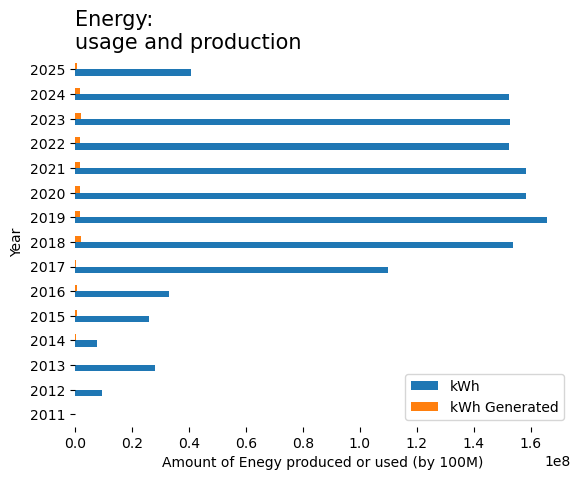

In [18]:
# Plot the data by year.
yearly.plot(x= 'Year', y= ['kWh', 'kWh Generated'], kind='barh')
# Label the title and axis.
plt.title('Energy: \nusage and production', fontsize = 15, loc='left')
plt.xlabel('Amount of Enegy produced or used (by 100M)')

plt.box(False)
plt.show()

In [19]:
# Rename solar flag anf month date for easier transformations. 
df.rename(columns={'Solar Flag': 'Solar'}, inplace=True)
df.rename(columns={'Month Date': 'Date'}, inplace=True)

In [20]:
# Seperate the data based on the solar flag yes or no.
no_solar = df[df.Solar == "No"]
solar = df[df.Solar == "Yes"]


In [21]:
# Drop the columns we will not be using.
no_solar = drop_columns(no_solar)

In [22]:
# Make sure the columns were dropped properly.
no_solar.head()

,Date,Year,Month,kWh
0,08/01/2011,2011,Aug,1253.0
1,12/01/2011,2011,Dec,12791.0
2,07/01/2011,2011,Jul,0.0
3,06/01/2011,2011,Jun,12088.0
4,05/01/2011,2011,May,2239.0


In [23]:
# Drop the columns we will not be using.
solar = drop_columns(solar)

In [24]:
# Make sure the columns were dropped properly.
solar.head()

,Date,Year,Month,kWh
37,04/01/2013,2013,Apr,19870.0
46,12/01/2013,2013,Dec,8749.0
65,07/01/2013,2013,Jul,59003.0
70,06/01/2013,2013,Jun,42150.0
75,03/01/2013,2013,Mar,16877.0


In [25]:
# Check for null values.
no_solar.isnull().sum()

Date        0
Year        0
Month       0
kWh      6153
dtype: int64

In [26]:
# Check for null values.
solar.isnull().sum()

Date      0
Year      0
Month     0
kWh      24
dtype: int64

In [27]:
# Drop the null values.
solar = solar.dropna()
no_solar = no_solar.dropna()

In [28]:
# Set the index to the date and calculate the mean for each month and reindex the data.
solar = solar.groupby('Date')['kWh'].mean().reset_index()
no_solar = no_solar.groupby('Date')['kWh'].mean().reset_index()

In [29]:
# Apply the date time conversion to both data sets.
solar = time_conversion(solar)
no_solar = time_conversion(no_solar)

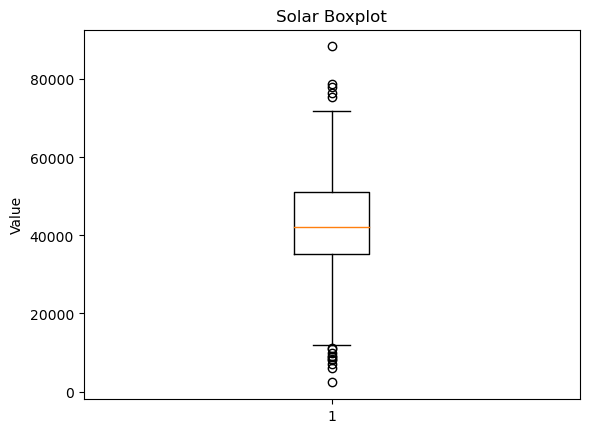

In [30]:
# Box plot the data to review for outliers.
box_plot(solar, 'Solar Boxplot')
plt.show()

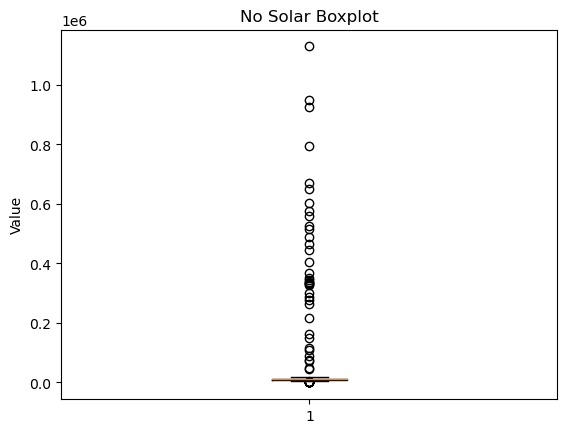

In [31]:
# Box plot the data to review for outliers.
box_plot(no_solar, 'No Solar Boxplot')
plt.show()

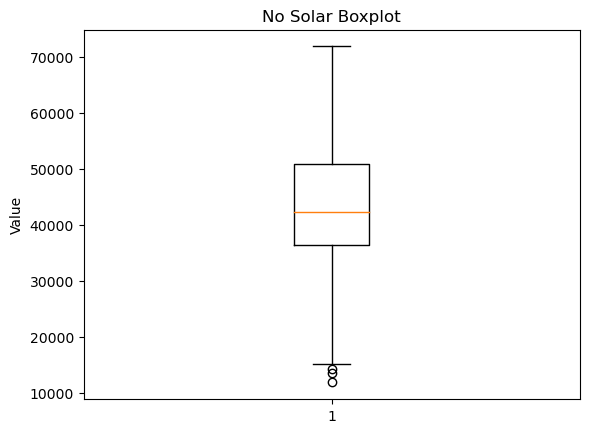

In [32]:
# Remove the outliers
solar =remove_outliers(solar)
no_solar = remove_outliers(no_solar)

# Plot the data to make sure the outliers were removed
box_plot(solar, 'No Solar Boxplot')
plt.show()

In [33]:
# Set the date as an index for both dataframes.
solar = solar.set_index("Date")
no_solar = no_solar.set_index("Date")

In [34]:
# makeing duplicate dataframes for the different models.
solar1 = solar
no_solar1 = no_solar

## Building the models.

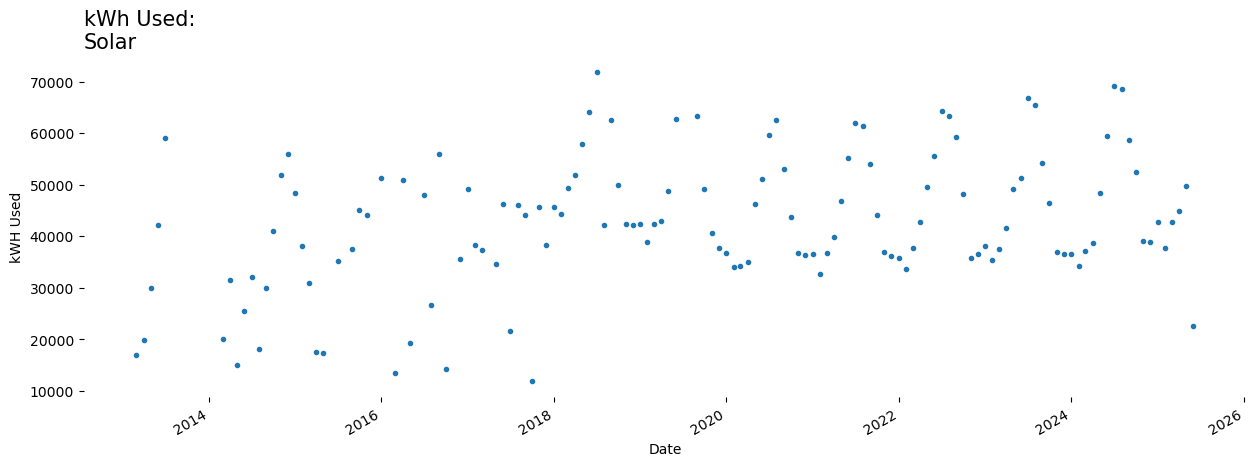

In [35]:
# Make a plot of the solar daat frame to aanlyze for patterns.
solar.plot(style='.', figsize=(15,5), legend=False)
# Apply a title and labels to the plot.
plt.title('kWh Used: \nSolar', fontsize = 15, loc="left")
plt.xlabel('Date')
plt.ylabel('kWH Used')

plt.box(False)
plt.show()

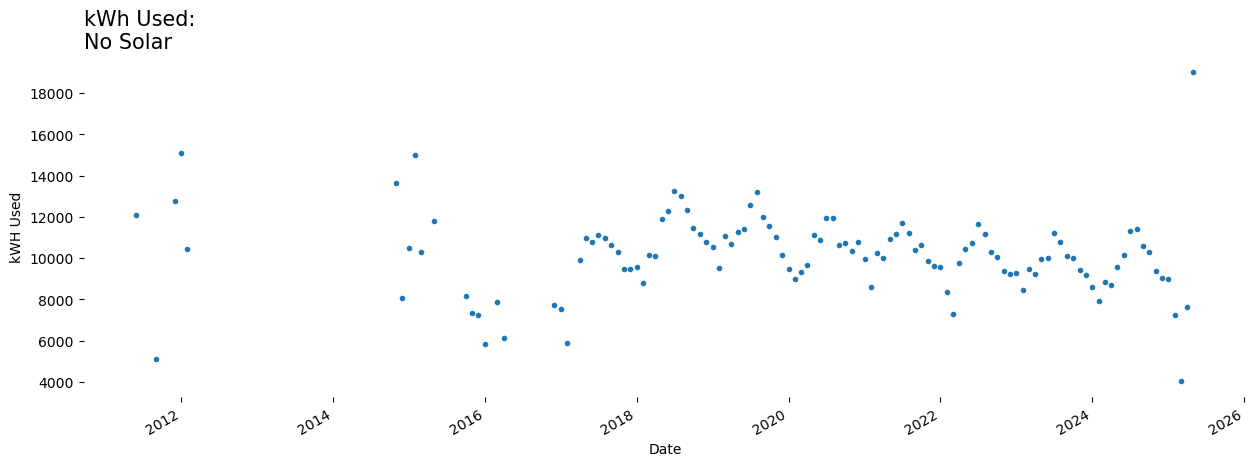

In [36]:
# Make a plot of the solar daat frame to aanlyze for patterns,
no_solar.plot(style='.', figsize=(15,5), legend=False)
# Apply a title and labels to the plot.
plt.title('kWh Used: \nNo Solar', fontsize = 15, loc="left")
plt.xlabel('Date')
plt.ylabel('kWH Used')

plt.box(False)
plt.show()

## Training the model XGBOOST for homes with solar

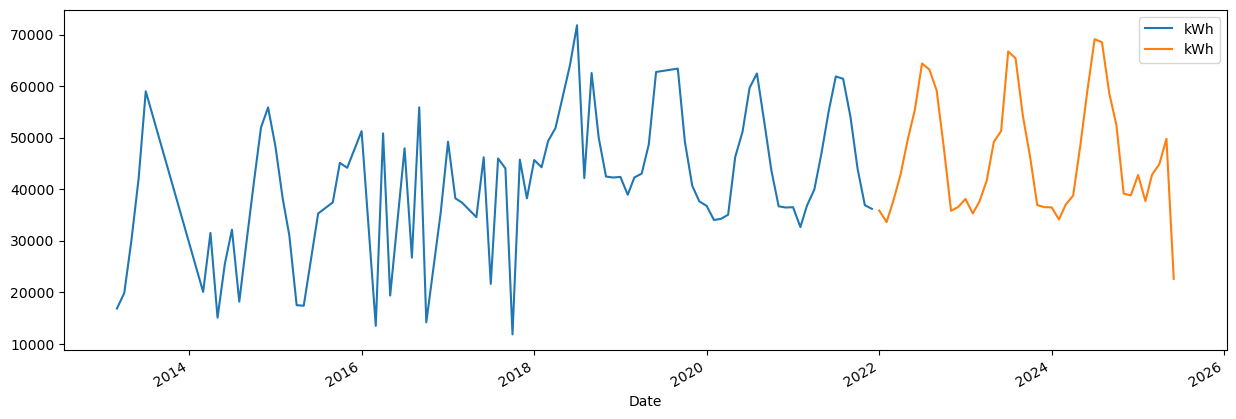

In [37]:
# Splt the data into training and testing sets. We'll be predicting 3 years of data.
train = solar.loc[solar.index < '01-01-2022']
test = solar.loc[solar.index >= '01-01-2022']

# Plot the training and testing data for the solar energy usage.
fig, ax = plt.subplots(figsize=(15, 5))
# plot and label the data.
train.plot(ax=ax, label='Training Data')
test.plot(ax=ax, label='Testing Data')
plt.show()

### Feture Creation

In [38]:
# adding month and year features to the model.
solar = feature_selection(solar)

In [39]:
# Resting the training and testing sets based on these fetures.
train = feature_selection(train)
test = feature_selection(test)

In [40]:
# Checking for the new columns of data.
solar.columns

Index(['kWh', 'Month', 'Year'], dtype='object')

In [41]:
# Setting fetures to month and year
features = ['Month', 'Year']
# Setting the target to the energy usage.
target = 'kWh'

In [42]:
# Resplitting the testing anf training data based on fetures and target.
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [43]:
# Run the get best function for the eleastic net features.
get_best(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'reg_alpha': 0.01, 'reg_lambda': 10}


In [44]:
# Run XGB regressor with elastic net over multiple estimators for the best model. 
reg = xgb.XGBRegressor(n_estimators = 10000, early_stopping_rounds=50, 
                       learning_rate=0.01, reg_alpa=0.01, reg_lambda=10)
# Fit the data to the best XGB model.
reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose = 100)

[0]	validation_0-rmse:13184.44949	validation_1-rmse:12347.75689
[100]	validation_0-rmse:9872.69664	validation_1-rmse:8854.50704
[200]	validation_0-rmse:8417.82606	validation_1-rmse:7542.97800
[300]	validation_0-rmse:7601.48215	validation_1-rmse:7042.04969
[400]	validation_0-rmse:6817.15201	validation_1-rmse:6771.90758
[500]	validation_0-rmse:6160.89964	validation_1-rmse:6631.82386
[600]	validation_0-rmse:5560.14723	validation_1-rmse:6551.76603
[700]	validation_0-rmse:5090.25369	validation_1-rmse:6490.95981
[800]	validation_0-rmse:4694.45684	validation_1-rmse:6432.05708
[900]	validation_0-rmse:4374.63270	validation_1-rmse:6396.79671
[1000]	validation_0-rmse:4107.28224	validation_1-rmse:6370.66173
[1098]	validation_0-rmse:3893.19370	validation_1-rmse:6394.91663


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

## Forecasting

In [45]:
# Make a new column for the predictions.
test['predictions'] = reg.predict(X_test)

In [46]:
# Merge the new columnon the existing dataframe. 
solar = solar.merge(test[['predictions']], how='left', left_index=True, right_index=True)
solar.head()

,kWh,Month,Year,predictions
Date,,,,
2015-01-01,48347.500000,1,2015,NaN
2016-01-01,51275.285714,1,2016,NaN
2017-01-01,49223.714286,1,2017,NaN
2018-01-01,45672.125000,1,2018,NaN
2019-01-01,42393.444444,1,2019,NaN


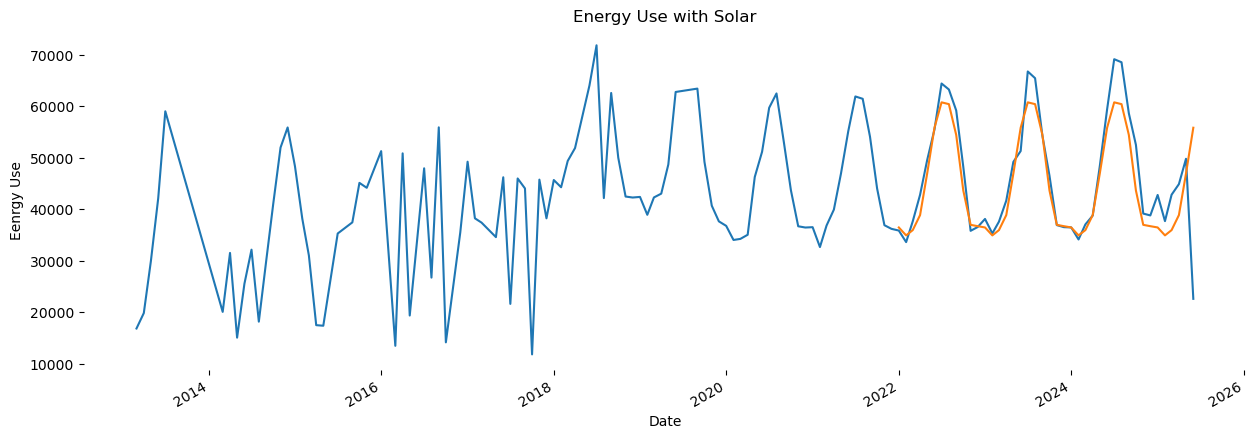

In [47]:
# Plot the XGB model.
ax = solar[['kWh']].plot(figsize=(15,5), legend=False)
solar['predictions'].plot(ax=ax)
# Apply a title and labels to the plot.
plt.title('Energy Use with Solar')
plt.ylabel('Eenrgy Use')
plt.box(False)
plt.show()

In [48]:
# Testing the model for accuracy.
score = np.sqrt(mean_squared_error(test['kWh'], test['predictions']))
mae = mean_absolute_error(test['kWh'], test['predictions'])
mape = mean_absolute_percentage_error(test['kWh'], test['predictions'])

print(f"RMSE: {score}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

RMSE: 6361.712943764057
MAE: 3665.902788111772
MAPE: 0.0922841845088476


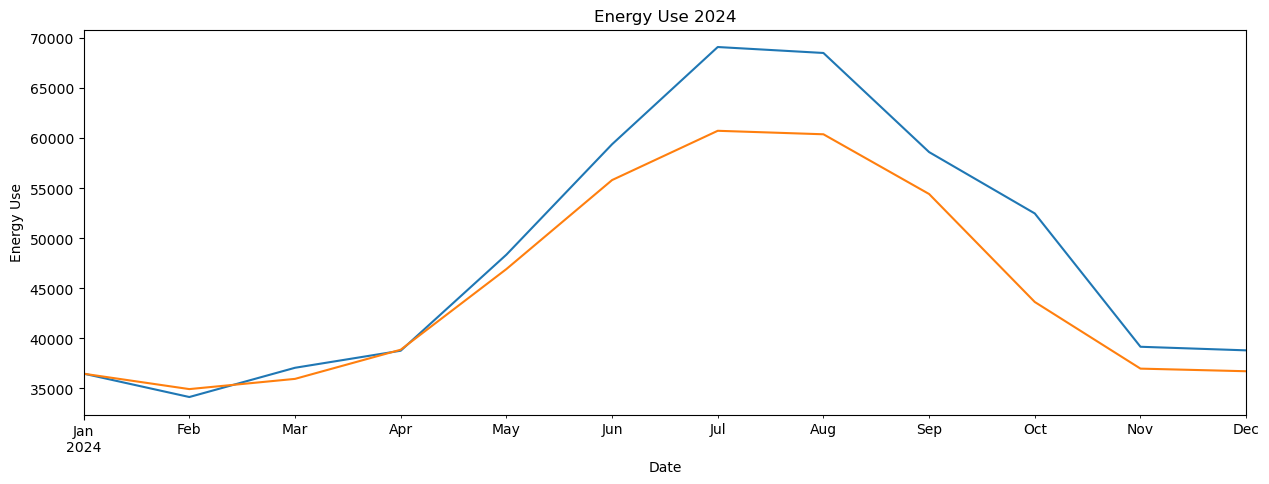

In [49]:
# Plot the model for 1-year term.
ax = solar.loc[(solar.index >= '01-01-2024') & (solar.index < '01-01-2025')]['kWh'].plot(figsize=(15,5), title='Energy Use 2024')
solar.loc[(solar.index>='01-01-2024')& (solar.index < '01-01-2025')]['predictions'].plot()
# Give the plot a title.
plt.ylabel('Energy Use')
plt.show()

## Training the model XGBOOST for homes with out solar

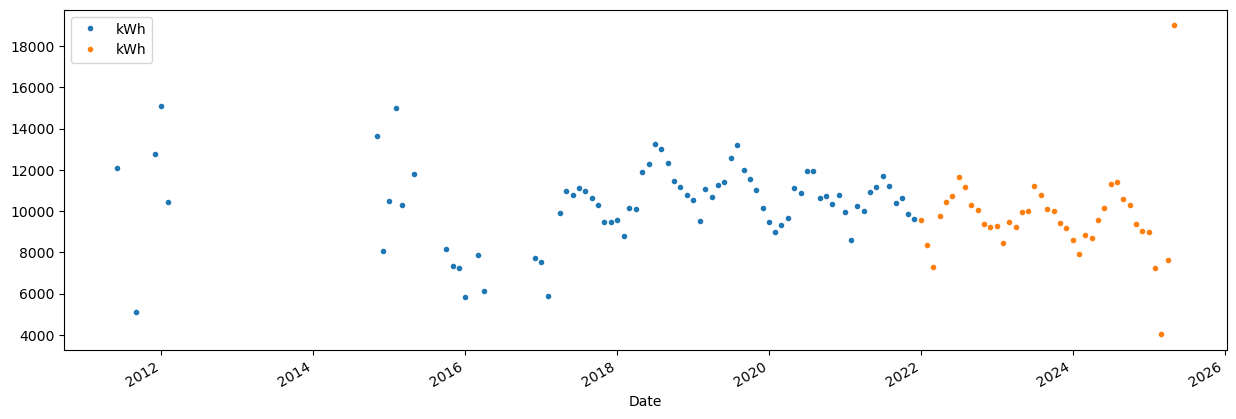

In [50]:
# Splt the data into training and testing sets. We'll be predicting 3 years of data.
train = no_solar.loc[no_solar.index < '01-01-2022']
test = no_solar.loc[no_solar.index >= '01-01-2022']

# Plot the training and testing data for the solar energy usage.
fig, ax = plt.subplots(figsize=(15, 5))
# Plot and label the plot.
train.plot(ax=ax, label='Training Data', style='.')
test.plot(ax=ax, label='Testing Data', style='.')
plt.show()

In [51]:
# adding month and year features to the model.
no_solar = feature_selection(no_solar)

In [52]:
# Reseting the training and testing sets based on these fetures.
train = feature_selection(train)
test = feature_selection(test)

In [53]:
# Checking for the new columns of data.
solar.columns

Index(['kWh', 'Month', 'Year', 'predictions'], dtype='object')

In [54]:
# Setting fetures to month and year.
features = ['Month', 'Year']
# Setting the target to the energy usage.
target = 'kWh'

In [55]:
# Resplitting the testing anf training data based on fetures and target.
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [56]:
# Run the get best function for the eleastic net features.
get_best(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'reg_alpha': 10, 'reg_lambda': 10}


In [57]:
# Run XGB regressor with elastic net over multiple estimators for the best model. 
reg = xgb.XGBRegressor(n_estimators = 10000, early_stopping_rounds=50, 
                       learning_rate=0.01, reg_alpa=10, reg_lambda=10)
# Fit the data to the best XGB model.
reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:1879.90658	validation_1-rmse:2127.41064
[100]	validation_0-rmse:1506.98322	validation_1-rmse:1986.61927
[200]	validation_0-rmse:1274.62077	validation_1-rmse:1927.27602
[300]	validation_0-rmse:1109.74263	validation_1-rmse:1868.89375
[400]	validation_0-rmse:988.61510	validation_1-rmse:1841.48165
[500]	validation_0-rmse:888.28940	validation_1-rmse:1822.63644
[600]	validation_0-rmse:813.24350	validation_1-rmse:1815.10886
[700]	validation_0-rmse:747.34692	validation_1-rmse:1809.63370
[800]	validation_0-rmse:688.15278	validation_1-rmse:1800.39637
[900]	validation_0-rmse:633.70101	validation_1-rmse:1797.46630
[1000]	validation_0-rmse:580.08108	validation_1-rmse:1795.48509
[1061]	validation_0-rmse:552.46085	validation_1-rmse:1796.25300


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

### Forecasting

In [58]:
# Make a new column for the predictions.
test['predictions'] = reg.predict(X_test)

In [59]:
# Merge the new columnon the existing dataframe. 
no_solar = no_solar.merge(test[['predictions']], how='left', left_index=True, right_index=True)
no_solar.head()

,kWh,Month,Year,predictions
Date,,,,
2012-01-01,15113.000000,1,2012,NaN
2015-01-01,10501.500000,1,2015,NaN
2016-01-01,5855.855941,1,2016,NaN
2017-01-01,7529.823590,1,2017,NaN
2018-01-01,9560.508612,1,2018,NaN


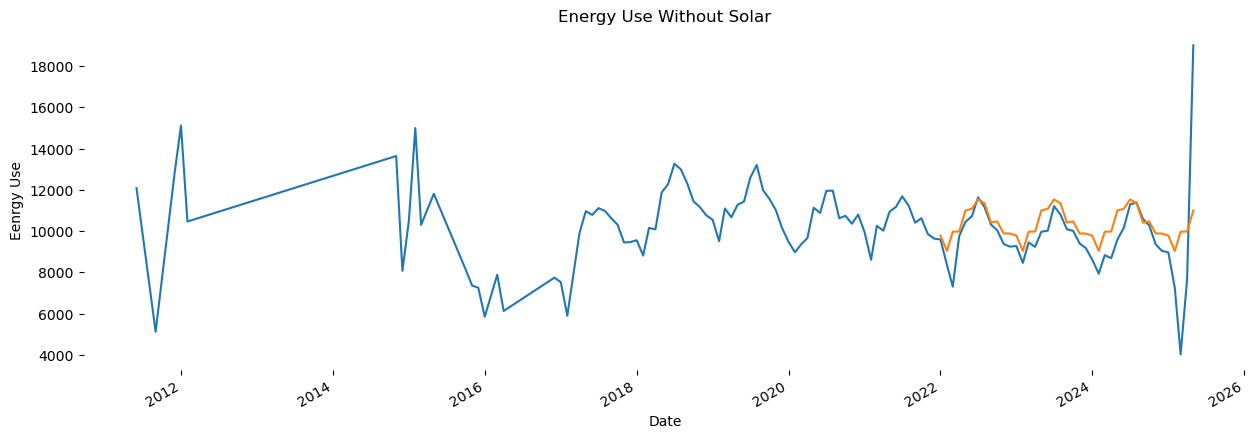

In [60]:
# Plot the XGB model.
ax = no_solar[['kWh']].plot(figsize=(15,5), legend=False)
no_solar['predictions'].plot(ax=ax)
# Apply a title and labels to the plot.
plt.title('Energy Use Without Solar')
plt.ylabel('Eenrgy Use')
plt.box(False)
plt.show()
plt.show()

In [61]:
# Testing the model for accuracy.
score = np.sqrt(mean_squared_error(test['kWh'], test['predictions']))
mae = mean_absolute_error(test['kWh'], test['predictions'])
mape = mean_absolute_percentage_error(test['kWh'], test['predictions'])

print(f"RMSE: {score}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

RMSE: 1795.4131174629679
MAE: 1020.5826200976732
MAPE: 0.12353823919799298


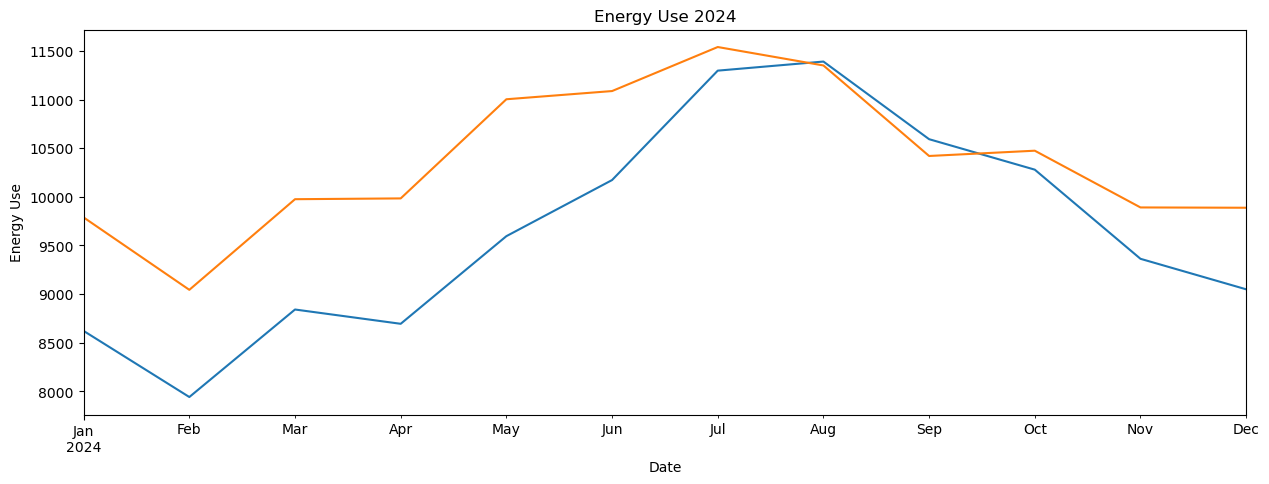

In [62]:
# Plot the model for 1-year term.
ax = no_solar.loc[(no_solar.index >= '01-01-2024') & (no_solar.index < '01-01-2025')]['kWh'].plot(figsize=(15,5), title='Energy Use 2024')
no_solar.loc[(no_solar.index>='01-01-2024')& (no_solar.index < '01-01-2025')]['predictions'].plot()
# Give the plot a title.
plt.ylabel('Energy Use')
plt.show()

# Profit Model on Solar Data

In [63]:
# Reset the index of the dataframe
solar1 = solar1.reset_index()
# Drop any columns that aren't needed.
solar1 = solar1.drop(columns=['Month', 'Year'])
solar1

,Date,kWh
0,2015-01-01,48347.500000
1,2016-01-01,51275.285714
2,2017-01-01,49223.714286
3,2018-01-01,45672.125000
4,2019-01-01,42393.444444
...,...,...
127,2020-12-01,36459.000000
128,2021-12-01,36199.777778
129,2022-12-01,36556.444444
130,2023-12-01,36529.333333


In [64]:
# The date needs to be converted to DS and the target to Y to use profit.
solar1 = solar1.rename(columns={'Date': 'ds', 'kWh': 'y'})
solar1

,ds,y
0,2015-01-01,48347.500000
1,2016-01-01,51275.285714
2,2017-01-01,49223.714286
3,2018-01-01,45672.125000
4,2019-01-01,42393.444444
...,...,...
127,2020-12-01,36459.000000
128,2021-12-01,36199.777778
129,2022-12-01,36556.444444
130,2023-12-01,36529.333333


In [65]:
# Set the model to a variable.
model = Prophet()

In [66]:
# Fit the model to the data.
model.fit(solar1)

14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
# Forecast the next year of data.
future = model.make_future_dataframe(periods=12, freq='M')
# Set the predictions to a variable.Needed for accuracy testing.
forecast = model.predict(future)

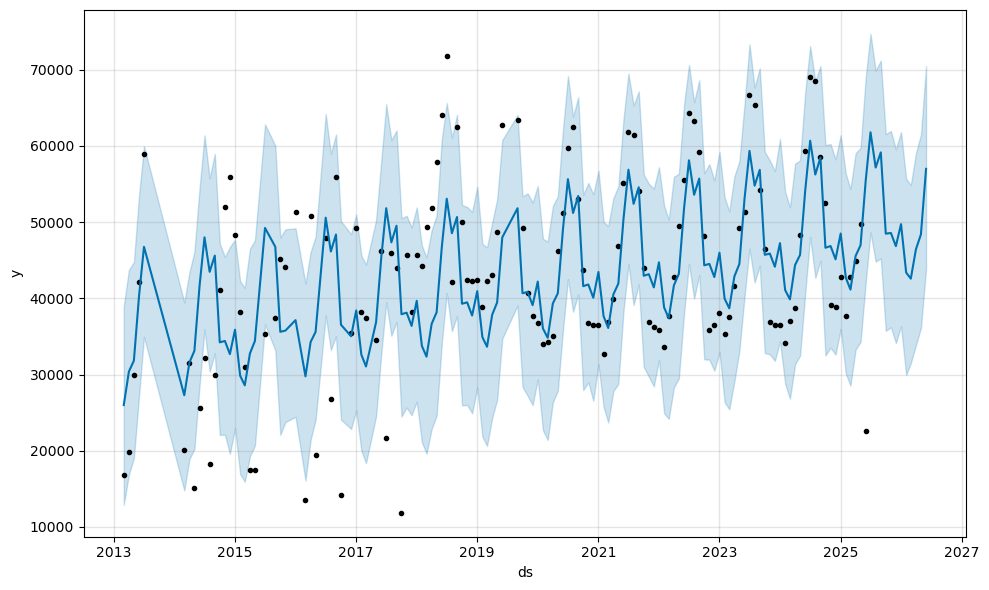

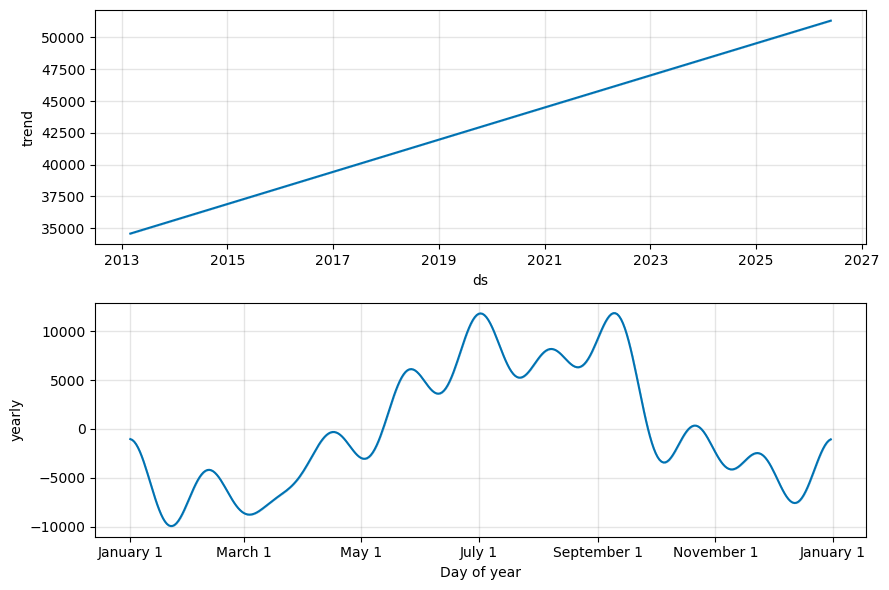

In [68]:
# Plot the model, trends, and the forecats.
plot(model, forecast)
plot_components(model, forecast)

# Save the plot as an image.
plt.savefig('profit Solar.jpg')
plt.show()

In [69]:
# Conduct a crossfold validation to obtain the best model. 
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
# Save the performance metrics.
df_p = performance_metrics(df_cv)
# Print the performance metrics.
print(df_p.head)

  0%|          | 0/19 [00:00<?, ?it/s]

14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:16 - cmdstanpy - INFO - Chain [1] start processing
14:19:16 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing
14:19:17 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1]

<bound method NDFrame.head of      horizon           mse          rmse           mae      mape     mdape  \
0    44 days  3.016181e+08  17367.155870  13814.518348  0.371186  0.285649   
1    45 days  3.004679e+08  17334.009952  13773.840704  0.365455  0.247388   
2    46 days  2.966708e+08  17224.134537  13676.278059  0.403881  0.247388   
3    49 days  3.043773e+08  17446.412576  14258.706640  0.421509  0.285649   
4    50 days  3.726332e+08  19303.710635  15733.749219  0.435381  0.286742   
..       ...           ...           ...           ...       ...       ...   
161 358 days  1.827453e+08  13518.333703  10867.737893  0.267943  0.282019   
162 360 days  1.735935e+08  13175.486864  10220.611523  0.250284  0.266592   
163 362 days  1.581799e+08  12576.960857   9612.656727  0.243172  0.148443   
164 363 days  1.619057e+08  12724.216773  10004.321757  0.253422  0.228551   
165 365 days  2.268581e+08  15061.808915  11541.590686  0.326238  0.266592   

        smape  coverage  
0    0.

## Prophet on no solar

In [70]:
# Reset the index of the dataframe.
no_solar1 = no_solar1.reset_index()
# Drop any columns we don't need. 
no_solar1 = no_solar1.drop(columns=['Month', 'Year'])
no_solar1

,Date,kWh
0,2012-01-01,15113.000000
1,2015-01-01,10501.500000
2,2016-01-01,5855.855941
3,2017-01-01,7529.823590
4,2018-01-01,9560.508612
...,...,...
113,2020-12-01,10800.975570
114,2021-12-01,9642.126511
115,2022-12-01,9249.908439
116,2023-12-01,9178.392885


In [71]:
# Change the date column to DS and the target column to Y.
no_solar1 = no_solar1.rename(columns={'Date': 'ds', 'kWh': 'y'})
no_solar1

,ds,y
0,2012-01-01,15113.000000
1,2015-01-01,10501.500000
2,2016-01-01,5855.855941
3,2017-01-01,7529.823590
4,2018-01-01,9560.508612
...,...,...
113,2020-12-01,10800.975570
114,2021-12-01,9642.126511
115,2022-12-01,9249.908439
116,2023-12-01,9178.392885


In [72]:
# Reset the model.
model = Prophet()

In [73]:
# Fit the data to the model.
model.fit(no_solar1)

14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
# Predict the next 12 months of energy usage.
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

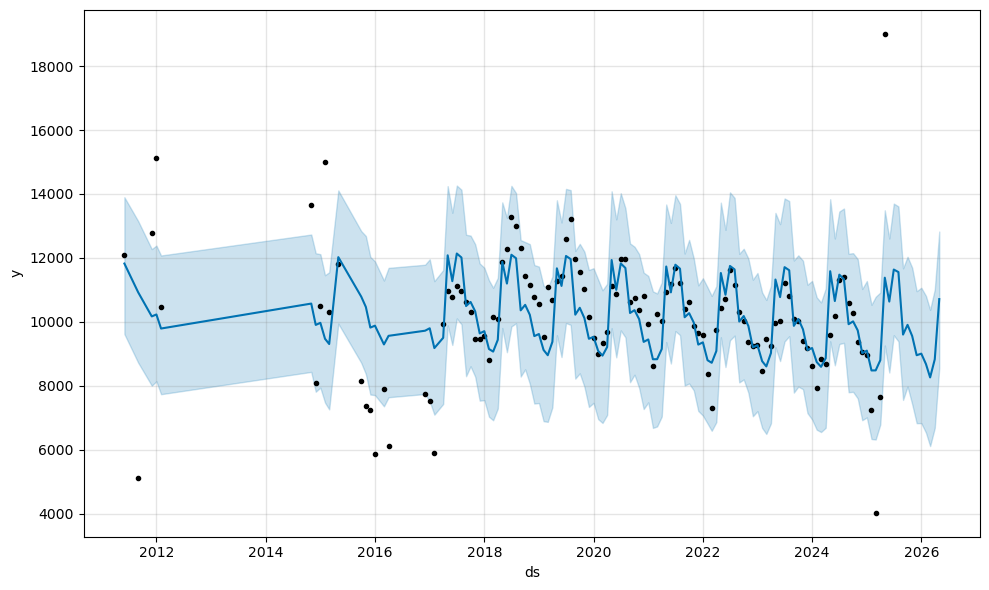

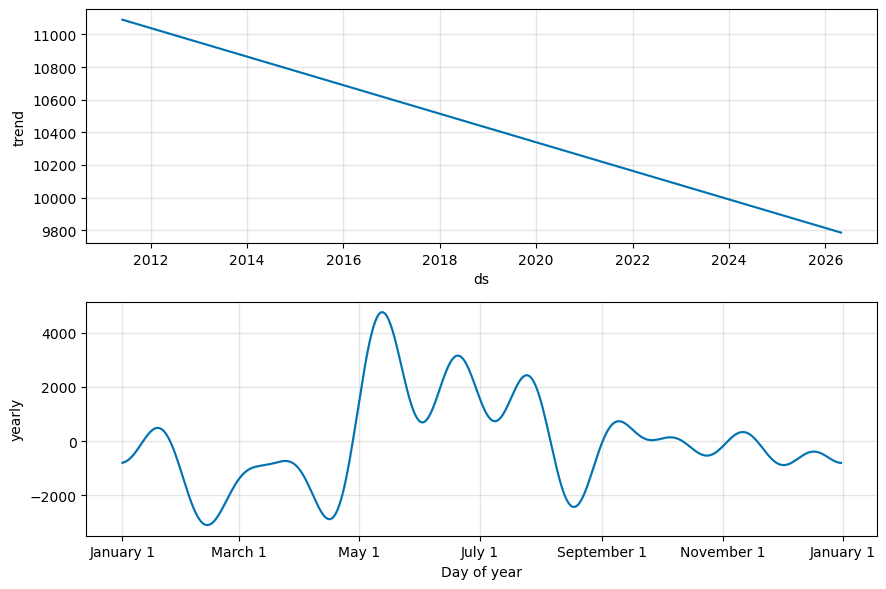

In [75]:
# Plot the model, trend, and the forecast.
plot(model, forecast)
plot_components(model, forecast)

#save the plot as a jpeg.
plt.savefig('Profit no Solar.jpg')
plt.show()

In [76]:
# Conduct a crossfold validation to obtain the best model. 
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
# Save the performance metrics.
df_p = performance_metrics(df_cv)
# Print the performance metrics.
print(df_p.head)

  0%|          | 0/22 [00:00<?, ?it/s]

14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing
14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing
14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing
14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing
14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] done processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1]

<bound method NDFrame.head of      horizon           mse          rmse          mae      mape     mdape  \
0    40 days  4.051172e+08  20127.523182  6554.357340  0.607880  0.093728   
1    43 days  4.140865e+08  20349.115537  7093.104947  0.640961  0.093728   
2    44 days  4.140463e+08  20348.128537  7067.218155  0.638989  0.092634   
3    45 days  4.140500e+08  20348.218936  7072.317614  0.639246  0.092634   
4    49 days  4.138821e+08  20344.092701  6988.605488  0.631602  0.070767   
..       ...           ...           ...          ...       ...       ...   
163 359 days  5.520488e+08  23495.718835  7498.565258  0.890945  0.159768   
164 360 days  5.520813e+08  23496.411341  7531.708211  0.894304  0.169056   
165 362 days  5.529003e+08  23513.832862  7626.483905  0.904384  0.169056   
166 364 days  5.527381e+08  23510.383135  7606.283864  0.902172  0.169056   
167 365 days  5.560135e+08  23579.937977  7949.328182  0.918466  0.199301   

        smape  coverage  
0    0.373770  0.68